# Subspace graph - revisit

Revisiting `001` but now extracting the principal components from the (more realistic) validation set, not the task dataset.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 1922977544
set_all_seeds(seed)
print(seed)

2256609523


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


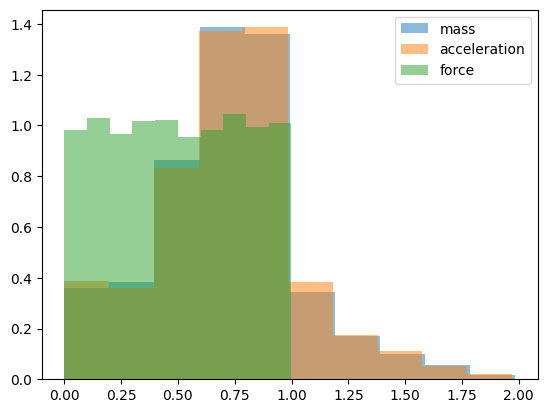

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

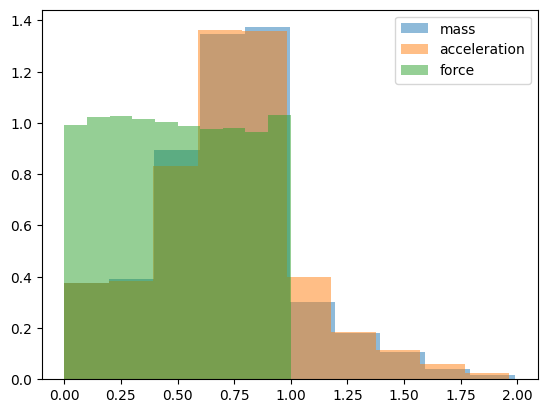

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 1000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

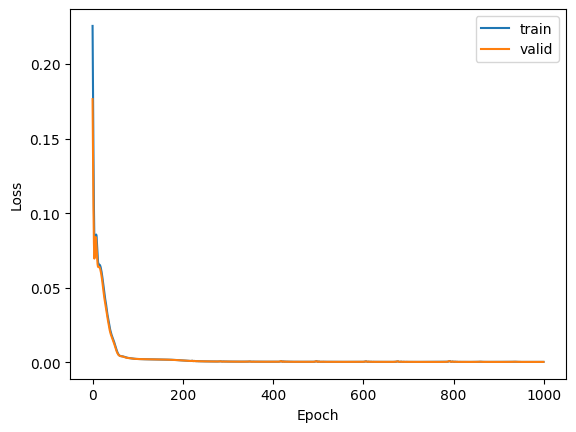

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0002)

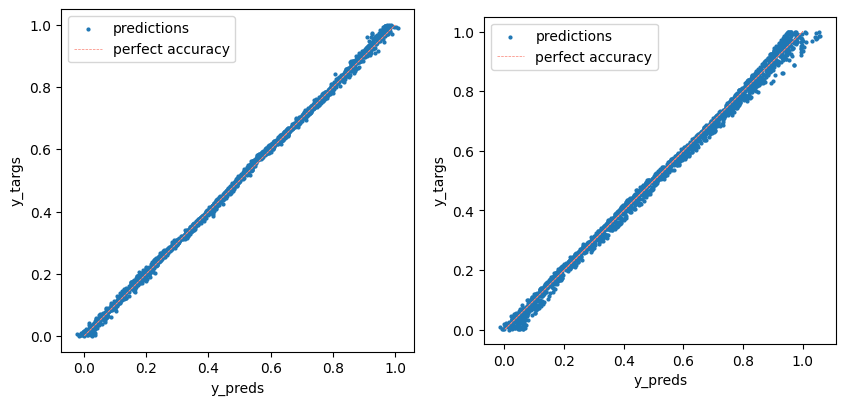

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [14]:
from physics_mi.analysis import capture_intermediate_outputs

In [15]:
def get_inputs(N=100, vary_task="A"):
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [16]:
task_inputs = torch.cat(
    (get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B"))
)
task_inputs.shape

torch.Size([20000, 4])

In [17]:
valid_ios = capture_intermediate_outputs(model, X_valid)
task_ios = capture_intermediate_outputs(model, task_inputs)

Now we'd like to compare the principal components at `layers.0.act` with those from `layers.1.act` I think.

In [18]:
def get_pcs(data):
    mean = torch.mean(data, 0)
    data_centered = data - mean

    # Step 2: Compute the SVD
    U, S, V = torch.svd(data_centered)

    # The columns of V are the principal components
    principal_components = V

    # Step 3: Compute variances
    variances = S.pow(2) / (data.size(0) - 1)

    return principal_components, variances

In [19]:
task_acts0 = task_ios["layers.0.act"]
task_acts1 = task_ios["layers.1.act"]
task_acts0.shape, task_acts1.shape

(torch.Size([20000, 16]), torch.Size([20000, 16]))

In [20]:
valid_acts0 = valid_ios["layers.0.act"]
valid_acts1 = valid_ios["layers.1.act"]
valid_acts0.shape, valid_acts1.shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [21]:
valid_pcs0, _ = get_pcs(valid_acts0)
valid_pcs1, _ = get_pcs(valid_acts1)
valid_pcs0.shape, valid_pcs1.shape

(torch.Size([16, 16]), torch.Size([16, 16]))

In [22]:
pc_acts0 = torch.matmul(valid_pcs0, task_acts0.T).T
pc_acts1 = torch.matmul(valid_pcs1, task_acts1.T).T
pc_acts0.shape, pc_acts1.shape

(torch.Size([20000, 16]), torch.Size([20000, 16]))

In [23]:
combined = torch.cat((pc_acts0, pc_acts1), dim=1)

# Compute the covariance matrix of the combined tensor, which will be [32, 32]
cov_matrix_full = torch.cov(combined.T)

# Extract the [16, 16] covariance matrix between X and Y
# This is the top-right or bottom-left quadrant of the full covariance matrix
cov_matrix_XY = cov_matrix_full[0:16, 16:32]

cross_cov_matrix = cov_matrix_XY.numpy()

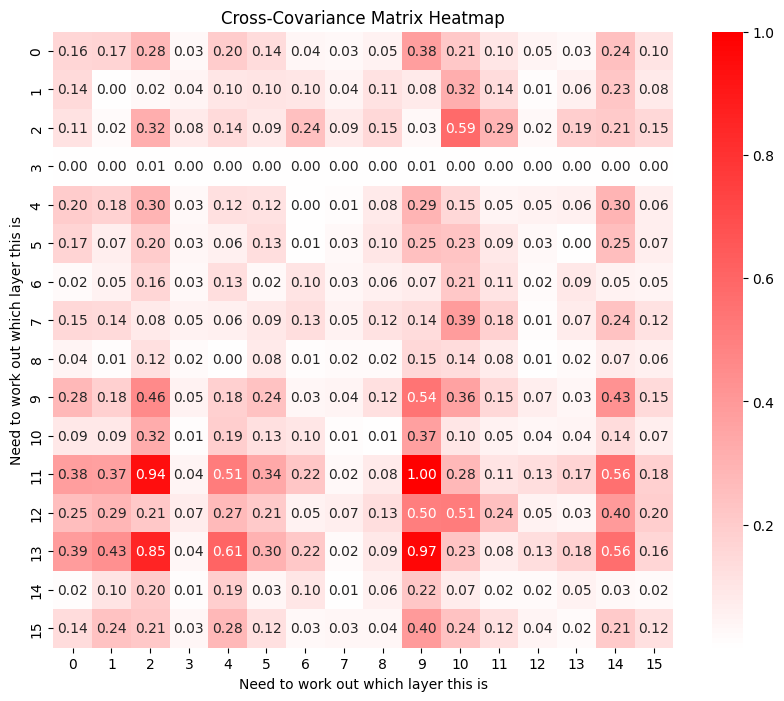

In [26]:
import seaborn as sns

# Plotting the heatmap
_, ax = plt.subplots(figsize=(10, 8))
CM = cross_cov_matrix / np.abs(cross_cov_matrix).max()
CM = np.abs(CM)
sns.heatmap(CM, annot=True, fmt=".2f", cmap="bwr", center=0, ax=ax)
ax.set_xlabel("Need to work out which layer this is")
ax.set_ylabel("Need to work out which layer this is")
_ = ax.set_title("Cross-Covariance Matrix Heatmap")

Hmm, just thinking. I suppose what _could_ happen here is that between each subsequent layer there could be a _combination_ of components for e.g. task A that cancel out when they vary for the components for task B. That's to say, that we might not expect there to be strict separation in the cross covariance matrix 🤔

I think a stricter definition of what I mean here is that by varying the different task components for task A in first layer (i.e. the input space to the second layer), it could result in a movement in a plane perpendicular to the principal components associated with task B in the second layer (in the perspective of the space accessed by the second layer).

If the network can do this, I have a strong feeling it will. Will need to have a think about what to do in this situation 🤔

## Having thought a little

Yes, I think this is likely to be an issue.

I was wondering, would it make _any_ sense to:
- transform the principal components of layer0 outputs
- do some comparison between these transformed components and the principal components for layer1 outputs?

I'm not sure if this makes sense because the components only really make sense in combination, not separately, and magnitude also counts.

Either way, my intuition is telling me that one _can't_ link the PCs from layer0 to the PCs in layer1 without some extra information about how those PCs are being transformed in between.

I wonder if principal component regression (PLSR is maybe the right one here) is something useful here? E.g. which components in the previous layer explain the greatest variance in the principal components at the current layer (not necessarily limited to the principal components from the previous layer). Then one could find the principal components of the previous layer which might contribute to this principal component to build up some kind of weighting?

Hmm but principal component regression to me might be just like training a linear layer much like the one we already have _although_ I suppose it's rotated to the principal component basis, not the neuron basis. Hmm might be worth a try.

I'd imagine that the PLSR components would tell us the combinations of the principal components that might interact to be important in the next layer. The next layer is going to be linearly accessing these spaces presumably. Maybe this is the rotated basis version of looking at neuron path dependence. 

I _still don't understand_ why people aren't thinking about bases other than the neuron basis more! Thinking from the perspective of pruning networks to subnetworks that carry out individual tasks, it still doesn't make sense in the neuron basis, because you'll always end up with task overlap if your task computation isn't aligned with the neurons (which I guess it often isn't). Even very small rotations from the neuron basis have the ability to spread that task across all of the neurons.